In [9]:
import numpy as np
import pylab as py
py.rcParams.update({'font.size': 22}) 

In [10]:
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import ipywidgets as widgets
from ipywidgets import interact
# Importujemy potrzebne biblioteki
from sklearn import datasets
from sklearn.svm import SVC



### Powtórka
* klasyfikacja/regresja
* klasyfikacja:
  * regresja logistyczna
  * regresja wieloraka
  * GAD i naiwny klasyfikator Bayesa
  

## Wstęp: Maszyny Wektorów Nośnych

* W tym wykładzie omówimy jeden z najbardziej popularnych algorytmów uczenia maszynowego: algorytm: Maszyny Wektorów Nośnych (ang. <i>Support Vector Machines</i> (SVM)).
* Bazuje on an koncepcji rozdzielenia danych należących do różnych klas możliwie dużą ”przerwą”. 
<!--![](SVM1.png "By User:ZackWeinberg, based on PNG version by User:Cyc - This file was derived from:  Svm separating hyperplanes.png, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=22877598")
<img src="https://drive.google.com/uc?id=1jZPSyXgjYdlEVNIikOfCsMtqA0HlUEHv" width = 800px> -->

In [11]:
# Generowanie danych - dwie liniowo separowalne grupy punktów
X, y = make_blobs(n_samples=100, centers=2, random_state=42, cluster_std=1.5)

# Funkcja rysująca punkty oraz prostą na podstawie współczynnika kierunkowego i wyrazu wolnego
def plot_with_line(a, b):
    plt.figure(figsize=(8,6))
    
    # Rysowanie punktów
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=50)
    
    # Rysowanie linii prostej: y = a * x + b
    x_vals = np.linspace(np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1, 100)
    y_vals = a * x_vals + b
    plt.plot(x_vals, y_vals, 'r', lw=3, label=f'y = {a:.2f}x + {b:.2f}')
    
    # Ustawienia wykresu
    plt.xlim(np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1)
    plt.ylim(np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1)
    plt.axhline(0, color='black',linewidth=1)
    plt.axvline(0, color='black',linewidth=1)
    plt.title("Dane separowalne liniowo:  która prosta separuje je optymalnie?")
    plt.legend()
    plt.grid(True)
    plt.show()

# Tworzenie suwaków do kontrolowania współczynnika kierunkowego i wyrazu wolnego
interact(plot_with_line, 
         a=widgets.FloatSlider(value=1.0, min=-5.0, max=5.0, step=0.1, description='Nachylenie'), 
         b=widgets.FloatSlider(value=0.0, min=-10.0, max=10.0, step=0.1, description='Wyraz wolny'));


interactive(children=(FloatSlider(value=1.0, description='Nachylenie', max=5.0, min=-5.0), FloatSlider(value=0…

## Marginesy
* Aby wprowadzić tą koncepcję zajmiemy się najpierw wypracowaniem pojęcia marginesu.

* Zacznijmy od wyrobienia sobie intuicji co do pewności predykcji. 
* Rozważmy regresję logistyczną. 
  * Prawdopodobieństwo przynależności do klasy 1 $p(y=1|x;\theta )$ dane jest tu przez hipotezę $h_{\theta }(x) = g(\theta ^{T}x) = \frac{1}{1+ \exp (-\theta ^{T}x)}$.
  

  * Umówimy się, że klasę 1 przypiszemy danym $x$ jeśli $h_{\theta }(x) \ge 0.5$, 
    * to odpowiada $\theta ^{T}x \ge 0$ (w przeciwnym razie klasę 0).

  * Dla wektora $x$ z klasy 1 jesteśmy tym bardziej pewni jego przynależności do tej klasy, im większe będzie $h_{\theta }(x)$ czyli, czym większe będzie $\theta ^{T}x$. 
    * Tak więc dla $\theta ^{T}x \gg 0$ jesteśmy bardzo pewni, że $x$ należy do klasy 1, 
    * zaś dla $\theta ^{T}x \ll 0$ jesteśmy bardzo pewni, że $x$ należy do klasy 0.

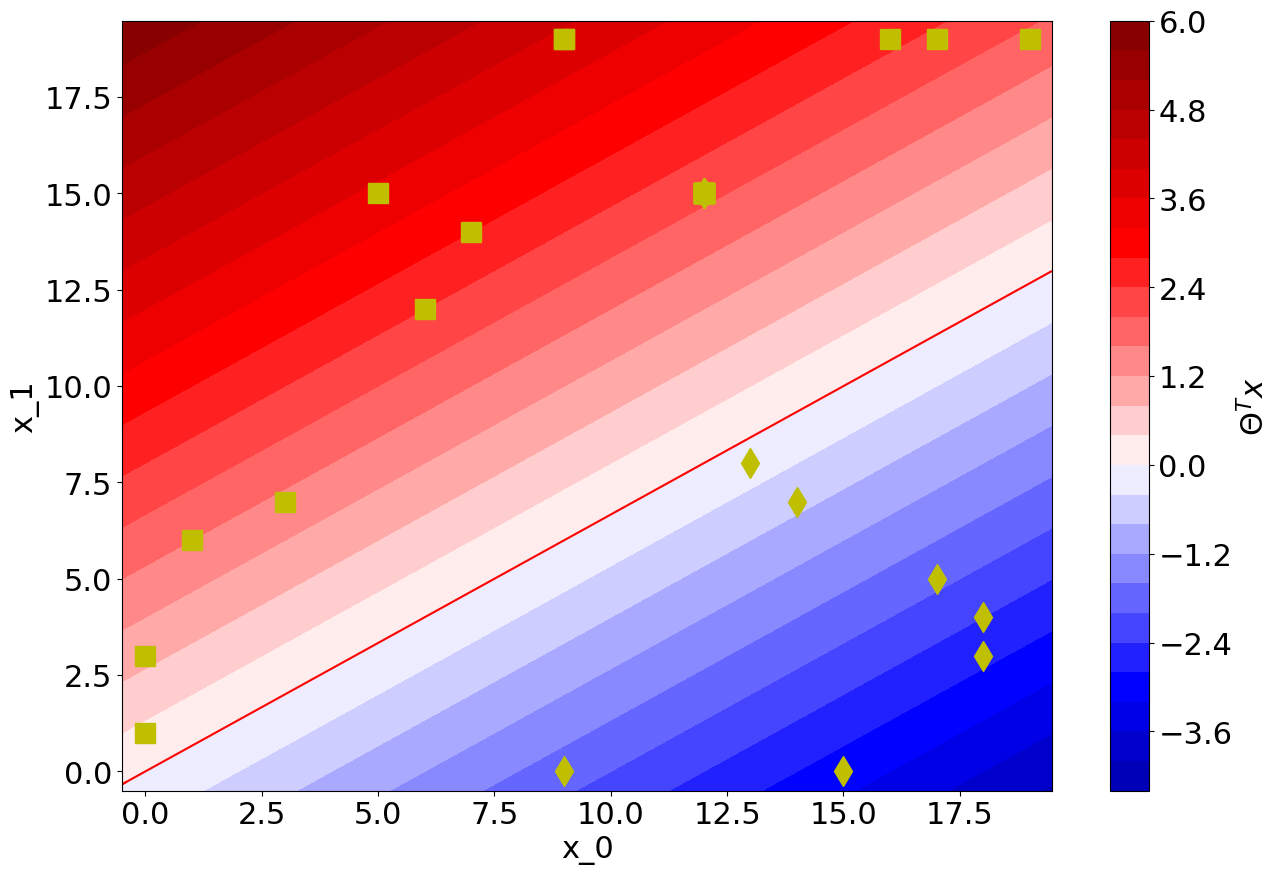

In [4]:
# ilustracja:
np.random.seed(0)
X = np.random.randint(20,size=(20,2))
theta = np.array([[-0.2],[0.3]])
Y = np.round( 1/(1+np.exp(np.dot(-X, theta))))
ind0 = np.where(Y==0)
ind1 = np.where(Y==1)

py.figure(figsize=(15,10))
py.plot(X[ind0,0],X[ind0,1],'yd', ms=15) 
py.plot(X[ind1,0],X[ind1,1],'ys', ms=15)
py.xlabel("x_0")
py.ylabel("x_1")
# szykuję siątkę 
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Obliczamy theta_t* x
Z = np.dot(np.c_[xx.ravel(), yy.ravel()],theta)
Z = Z.reshape(xx.shape)


py.contourf(xx,yy,Z,30,cmap = 'seismic',vmin=-6, vmax =6) 
py.colorbar(label = "$\Theta^{T}x$")

py.contour(xx,yy,Z,0,colors= ['red'])# rysuję kontur rozdzielający klasy
py.xlim(xx.min(), xx.max())
py.ylim(yy.min(), yy.max())
py.show()

Tak więc mając zbiór uczący wydaje się pożądane znalezienie takich parametrów $\theta $, że dla każdego elementu tego zbioru jeśli należy on do klasy 1 ($y^{(j)}=1$) to mamy $\theta ^{T}x^{(j)}\gg 0$, zaś jeśli należy on do klasy 0 ($y^{(j)}=0$) to mamy $\theta ^{T}x^{(j)}\ll 0$. Tą intuicję sformalizujemy za chwilę w postaci koncepcji marginesów funkcjonalnych.

Na zagadnienie klasyfikacji możemy też spojrzeć geometrycznie. Na zbiór uczący patrzymy jako na zbiór punktów w przestrzeni wejść oznaczonych etykietkami '1' lub '0'. Konstrukcja klasyfikatora polega na znalezieniu prostej (w dwóch wymiarach, w ogólności hiperpowierzchni) możliwie dobrze separującej elementy oznaczone różnymi etykietkami. Równanie hiperpowierzchni dane jest przez $\theta ^{T}x = 0$. Jeśli teraz dostaniemy nowy punkt $x$ do klasyfikacji to jesteśmy tym bardziej pewni decyzji, im dalej ten punkt leży od owej hiperpowierzchni. Zatem intuicyjnie wydaje się sensowne szukanie takiej hiperpowierzchni, aby elementy zbioru uczącego leżały możliwie daleko od niej. Tą intuicję sformalizujemy za chwilę w postaci koncepcji marginesów geometrycznych.

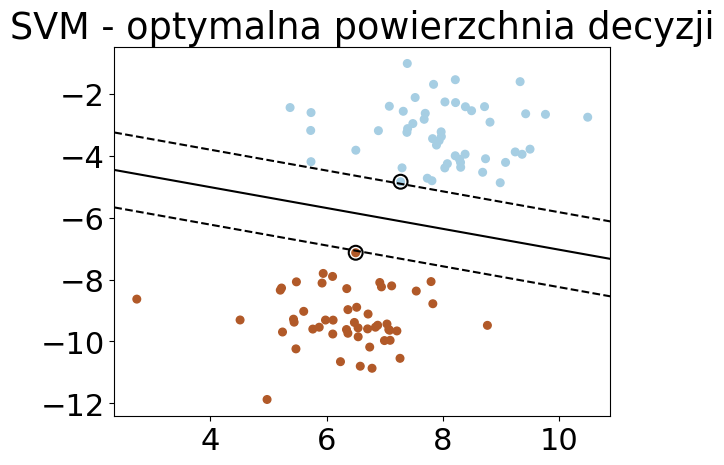

In [5]:
# Tworzymy dane: prosty zestaw punktów dwuwymiarowych
X, y = datasets.make_blobs(n_samples=100, centers=2, random_state=6)

# Tworzymy model SVM z jądrem liniowym
svm = SVC(kernel='linear', C=1.0)
svm.fit(X, y)

# Funkcja do rysowania marginesów i wektora normalnego
def plot_svm_margin(model, X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

    # Rysujemy granice decyzji
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Pobieramy współczynniki modelu
    w = model.coef_[0]
    intercept = model.intercept_[0]

    # Wyliczamy nachylenie i intercept
    slope = -w[0] / w[1]
    intercept = -intercept / w[1]

    # Generujemy linie decyzji
    xx = np.linspace(xlim[0], xlim[1])
    yy = slope * xx + intercept
    plt.plot(xx, yy, 'k-')

    # Obliczamy margines (odległość od powierzchni decyzyjnej)
    margin = 1 / np.sqrt(np.sum(w ** 2))

    # Rysujemy marginesy
    yy_margin_pos = yy + margin
    yy_margin_neg = yy - margin
    plt.plot(xx, yy_margin_pos, 'k--')
    plt.plot(xx, yy_margin_neg, 'k--')

    # Rysujemy wektory wspierające
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
                facecolors='none', edgecolors='k', linewidths=1.5)

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("SVM - optymalna powierzchnia decyzji")
    plt.show()

# Wywołujemy funkcję do rysowania
plot_svm_margin(svm, X, y)


### Uwaga o notacji

Łatwiej będzie myśleć o hiprepowierzchniach jeśli listę parametrów $\theta $ rozdzielimy na $w$ i $b$ tak, że $\theta ^{T}x = w^{T}x + b$. W tej wersji notacji nie potrzebujemy też $x_{0}=1$.

Z kolei łatwiej będzie się liczyło jeśli zmienimy etykietki klas z '0' i '1' na '-1', '1'. Zatem na potrzeby opisu SVM przyjmiemy, że $y \in \lbrace -1,1\rbrace $.

Zamiast zwracać prawdopodobieństwa przynależności $x$ do klas, które musielibyśmy progować i następnie przydzielać $x$-om etykietki zastosujemy funkcję, która od razu zwraca etykietki:

$\qquad 
h_{w,b}(x) = g(w^{T}x+b) = \left\lbrace  \begin{array} {rcl} 1 & dla & w^{T}x+b \ge 0 \\ -1 & dla & w^{T}x+b < 0 \\ \end{array} \right.
$

## Marginesy funkcjonalne i geometryczne

### Marginesy funkcjonalne

Dla przykładu ze zbioru uczącego $(x^{(j)},y^{(j)})$ definiujemy margines funkcjonalny jako:

$\qquad 
{\hat{\gamma}}\;\; ^{(j)} = y^{(j)}(w^{T}x^{(j)} + b)
$

Zauważmy, że:
* dla $y^{(j)}=1$ mamy duży margines funkcjonalny jeśli $w^{T}x^{(j)} +b$ jest dużą dodatnią liczbą. 
* dla $y^{(j)}=-1$ mamy duży margines funkcjonalny jeśli $w^{T}x^{(j)} +b$ jest dużą ujemną liczbą. 
    (-> rzućmy okiem na rys.)
* Ponadto jeśli klasyfikacja jest prawidłowa to margines funkcjonalny jest dodatni. 

A zatem dobre parametry $w$ i $b$ powinny dawać duże wartości marginesów funkcjonalnych. 

> Jedynym problemem takiej definicji marginesów funkcjonalnych jest to, że można je uczynić dowolnie dużymi przez przemnożenie $w$ i $b$ przez odpowiednio dużą liczbę. 

Wydaje się zatem rozsądne aby do powyższej definicji dodać warunek normalizacji zamieniając $(w,b)$ na $\left( \frac{w}{||w||},\frac{b}{||w||}\right)$.

### Margines funkcjonalny dla zbioru uczącego
Definicję marginesu funkcjonalnego dla całego zbioru uczącego otrzymujemy wybierając najgorszy przypadek spośród wszystkich marginesów funkcjonalnych dla poszczególnych elementów zbioru:

$\qquad 
\hat{\gamma }= \min _{j=1,\dots ,m} \hat{\gamma }\;\;^{(j)}
$

### Marginesy geometryczne

* Margines geometryczny $\gamma ^{(j)}$ to odległość danego punktu $x^{(j)}$ od hiperpowierzchni rozdzielającej. 
* Aby ją znaleźć trzeba obliczyć długość wektora prostopadłego do hiperpowierzchni, o który należy przesunąć punkt $x^{(j)}$ aby znalazł się on na hiperpowierzchni. 
* Jednostkowy wektor prostopadły do hiperpowierzchni ma współrzędne: $\frac{w}{||w||}$. Przesunięcie punktu $x^{(j)}$ w kierunku tego wektora otrzymujemy jako $x^{(j)} + \alpha \frac{w}{||w||}$. 
* Jeśli nasz przesunięty punkt ma się znaleźć na hiperpowierzchni separującej to musi spełniać jej równanie (długość tego wymaganego przesunięcia to poszukiwany margines geometryczny $\gamma ^{(j)}$). 
* Dla przypadku $y^{(j)}=1$ mamy:

$\qquad 
w^{T}\left(x^{(j)} - \gamma ^{(j)} \frac{w}{||w||} \right) +b=0
$

Rozwiązując to równanie ze względu na $\gamma ^{(j)}$ dostajemy:

$\qquad 
w^{T}x^{(j)} - \gamma ^{(j)} \frac{w^{T}w}{||w||}  +b=0
$

$\qquad 
w^{T}x^{(j)} +b = \gamma ^{(j)} \frac{||w||^2}{||w||}
$

$\qquad 
\gamma ^{(j)} = \frac{w^{T}x^{(j)} +b}{||w||} = \left( \frac{w}{||w||} \right)^{T} x^{(j)}+\frac{b}{||w||}
$

* Przypadek $x^{(j)}$ z klasy $y^{(j)} = -1$ wymagałby przesunięcia w kierunku zgodnym z wektorem normalnym do hiperpowierzchni. 
* Czyli aby uwzględnić oba przypadki jednocześnie możemy zapisać:

$\qquad 
\gamma ^{(j)} = y^{(j)}\left( \left(\frac{w}{||w||}\right)^{T}x^{(j)} + \frac{b}{||w||}\right)
$

Zauważmy, że dla znormalizowanego $w$ ($||w||=1$) dostajemy, że margines funkcjonalny równy jest marginesowi geometrycznemu. 

I podobnie jak dla marginesów funkcjonalnych, definiujemy margines geometryczny względem zbioru uczącego jako najgorszy przypadek:

$\qquad 
\gamma = \min _{j=1,\dots ,m} \gamma ^{(j)}
$

## Klasyfikator optymalny pod względem marginesów -

## podstawowa wersja SVM

Chwilowo zajmiemy się tylko problemami liniowo separowalnymi.

W języku wprowadzonych powyżej definicji możemy powiedzieć, że optymalny jest ten klasyfikator, który daje możliwie największy margines geometryczny (wtedy dane ze zbioru uczącego rozseparowane są przerwą o szerokości co najmniej dwóch marginesów).

> Jak wyznaczyć jego parametry?

### Wersja 1
Dla ustalonego zbioru uczącego możemy sformułować następujący problem optymalizacyjny:

$\qquad \begin{matrix}
\max _{w,b} \gamma && \\
&\textrm {p.w.:} &y^{(j)}(w^{T}x^{(j)}+b) \ge \gamma , \; j = 1,\dots ,m \\
&&||w|| =1
\end{matrix}$

* oznacza to, że chcemy zmaksymalizować $\gamma $ ale pod warunkiem, że margines funkcjonalny dla każdego przykładu ze zbioru uczącego jest nie mniejszy niż $\gamma $. 
* Dodatkowy warunek $||w||=1$ z jednej strony gwarantuje, że nie osiągniemy poprzedniego warunku przez przeskalowanie parametrów w marginesie funkcjonalnym, a z drugiej strony gwarantuje, że marginesy funkcjonalne i geometryczne są sobie równe.

> Taka formulacja problemu optymalizacyjnego jest jednak bardzo niewygodna. W szczególności warunek $||w||=1$ powoduje, że problem nie jest wypukły (cechą wypukłych problemów optymalizacyjnych jest to, że mają jedno ekstremum, zatem jest to ekstremum globalne).

### Wersja 2
Spróbujmy zatem przeformułować ten problem. Skorzystajmy z zależności między marginesem funkcjonalnym a geometrycznym: $\gamma = \hat{\gamma }\;\;/||w||$. Rozważmy:


$\begin{matrix}
\max _{w,b} \frac{\hat{\gamma }\;\;(w,b)}{||w||}&& \\
&\textrm {p.w.:} &y^{(j)}(w^{T}x^{(j)}+b) \ge \hat{\gamma }, \; j = 1,\dots ,m\end{matrix}$

* chcemy znaleźć parametry maksymalnego znormalizowanego marginesu funkcjonalnego. 
* Pozbyliśmy się dzięki temu niewygodnego warunku $||w||=1$, ale za to mamy niewygodną funkcję celu. 
 
 > Musimy jeszcze trochę popracować.

### Z własności marginesów ...
Pamiętamy, że skalując współczynniki $w$ i $b$ możemy uzyskać dowolną wartość marginesu funkcjonalnego. Weźmy zatem takie skalowanie, żeby dla zadanego zbioru uczącego otrzymać:

$\qquad 
\hat{\gamma }=1
$

Możemy takie skalowanie zapewnić, bo gdybyśmy znali jakieś $w$ i $b$ będące rozwiązaniem problemu optymalizacyjnego, które dają margines funkcjonalny $\gamma ^{*}$ to dzieląc to $w$ i $b$ przez $\gamma ^{*}$ dostajemy margines funkcjonalny równy 1.

### Obserwacje 
Wstawmy zatem $\hat{\gamma }= 1$ do formulacji (2):

$\qquad \begin{matrix}
\max _{w,b} \frac{1}{||w||}&& \\
&\textrm {p.w.:} &y^{(j)}(w^{T}x^{(j)}+b) \ge 1, \; j = 1,\dots ,m
\end{matrix}$

Zauwżmy, że:

$\qquad 
\max _{w,b} \frac{1}{||w||} \Leftrightarrow \min _{w,b} ||w|| \Leftrightarrow \min _{w,b}||w||^{2}
$

### Wersja 3
Dzięki tej obserwacji możemy nasz problem optymalizacyjny zapisać w wygodnej formie:

$\qquad \begin{matrix}
\min _{w,b} ||w||^{2}&& \\
&\textrm {p.w.:} &y^{(j)}(w^{T}x^{(j)}+b) \ge 1, \; j = 1,\dots ,m
\end{matrix}$

* funkcja celu jest funkcją wypukłą i w związku z tym posiada dokładnie jedno minimum, zatem jest to minimum globalne. 
* Co więcej do przeprowadzenia takiej minimalizacji wypukłej z więzami istnieje wiele gotowych bibliotek numerycznych.

## Dygresja
W zasadzie w tym miejscu można by powiedzieć, że mamy rozwiązany problem.

Zrobimy jednak w tym miejscu dygresję o mnożnikach Lagrangea, które to pozwolą na uzyskanie jeszcze dogodniejszej postaci problemu i rozszerzenia metody SVM na bardzo wielowymiarowe wektory cech.

### Mnożniki Lagrangea

Metoda mnożników Lagrangea jest ogólnym sposobem rozwiązywania problemów optymalizacyjnych z więzami. Mogliście już o niej słyszeć np. na mechanice klasycznej.

Dla przypomnienia:
Niech nasz problem optymalizacyjny będzie dany przez:


$\begin{matrix}
\min _{w}f(w)&\\
\textrm {p.w.: }&h_{i}(w) =0, i =1,\dots ,l
\end{matrix}$


Aby go rozwiązać budujemy tzw. lagrangian:

$\qquad 
\mathcal {L}(w,\beta ) = f(w) + \sum _{i=1}^{l} \beta _{i}h_{i}(w)
$

współczynniki $\beta _{i}$ to właśnie mnożniki Lagrangea. 

Rozwiązaniem wspomnianego wyżej problemu minimalizacyjnego jest rozwiązanie równań:

$\qquad 
\frac{\partial \mathcal {L}}{\partial w_{i}} = 0; \quad \frac{\partial \mathcal {L}}{\partial \beta _{i}} = 0
$

Podejście to można rozszerzyć na problemy optymalizacyjne posiadające więzy w postaci nierówności, tzn takich jak poniższy:


$\begin{matrix}
\min _{w} = f(w) && \\
\textrm {pod warunkiem:} & g_{i}(w)\le 0 , &i = 1,\dots ,k \\
& h_{i} (w) = 0 ,& i = 1,\dots , l
\end{matrix}$


Aby rozwiązać ten problem musimy najpierw zdefiniować uogólniony lagrangian z mnożnikami $\alpha _{i}$ i $\beta _{i}$:

$\qquad 
\mathcal {L}(w,\alpha ,\beta ) = f(w) + \sum _{i=1}^{k} \alpha _{i}g_{i}(w) + \sum _{i=1}^{l} \beta _{i}h_{i}(w)
$

#### Problem pierwotny
Rozważmy wielkość $\theta _{p}(w)$ zdefiniowaną:

$\qquad 
\theta _{p}(w) = \max _{\alpha ,\beta :\alpha _{i} \ge 0} \mathcal {L}(w,\alpha ,\beta )
$

Ma ona tę własność, że jeśli któryś z warunków nie jest spełniony to wybucha ona do nieskończoności (np. dla $g_{3}(w)>0$ maksymalizacja $\theta _{p}$ po parametrze $\alpha _{3}$ dałoby $\alpha _{3} = \infty $ a co za tym idzie cały $\mathcal {L} = \infty $. Podobnie dla naruszenia warunku $h_{i}(w) = 0$ dla jakiegoś $i$ spowoduje, że odpowiednie $\beta _{i} = \infty $ i $\mathcal {L} = \infty $.) Natomiast jeśli wszystkie warunki są spełnione to $\theta _{p} = f(w)$:

$\qquad 
\theta _{p} = \left\lbrace 
\begin{array}{ll}
f(w)& \textrm {jesli } w \textrm { spełnia warunki} \\
\infty &\textrm {w przeciwnym wypadku}
\end{array}
\right.
$

Zatem rozwiązanie naszego pierwotnego problemu $p^{*}$ może być zapisane w zwarty sposób tak:

$\qquad 
p^{*} = \min _{w} \theta _{p}(w) = \min _{w} \max _{\alpha ,\beta : \alpha _{i }\ge 0 } \mathcal {L}(w,\alpha ,\beta )
$

#### Problem dualny
A teraz przyjrzyjmy się innemu problemowi, który nazywa się dualnym do pierwotnego.
Definiujemy wielkość $\theta _{d}$:

$\qquad 
\theta _{d} (\alpha ,\beta ) = \min _{w} \mathcal {L}(w,\alpha ,\beta )
$

O ile wielkość $\theta _{p}$ była wartością lagrangianu zmaksymailzowanego względem $\alpha $ i $ \beta $ to
wielkość $\theta _{d}$ jest wartością tego lagrangianu zminimalizowanego po $w$. Dualny problem optymalizacyjny polega na znalezieniu takiego $d^{*}$, że:

$\qquad 
d^{*} = \max _{\alpha ,\beta : \alpha
_{i}\ge 0} \theta _{d} = \max _{\alpha ,\beta : \alpha _{i}\ge 0} \min _{w} \mathcal {L}(w,\alpha ,\beta )
$

Widać, że **problem pierwotny różni się od dualnego kolejnością operacj max i min**. Można też zauważyć, że w ogólności zachodzi relacja:

$\qquad 
d^{*} = \max _{\alpha ,\beta : \alpha _{i}\ge 0} \min _{w} \mathcal {L}(w,\alpha ,\beta ) \le \min _{w} \max _{\alpha ,\beta : \alpha _{i}\ge 0} \mathcal {L}(w,\alpha ,\beta ) =p^{*}
$
##### Na przykład:
$\max_{y\in\{0,1\}}(\min_{x\in\{0,1\}}1\{x==y\})$ 

$\min_{x\in\{0,1\}}(\max_{y\in\{0,1\}}1\{x==y\})$

#### Kiedy te problemy mają to samo rozwiązanie? - warunki KKT
Pod pewnymi warunkami zachodzi nawet coś ciekawszego a mianowicie:

$\qquad 
d^{*} = p^{*}
$

czyli zamiast rozwiązywać pierwotny problem, możemy rozwiązać problem dualny i stwierdzić, że jest on rozwiązaniem problemu pierwotnego.

Równość ta zachodzi pod następującymi warunkami: 
* $f$ i $g_{i}$ muszą być wypukłe, 
* $h_{i}$ muszą być afiniczne (tzn. postaci $h_{i}(w) = a_{i}^{T}w + b_{i}$), 
* oraz dla pewnego $w$ zachodzi $g_{i}(w) <0$. 
Pod tymi warunkami istnieją $w^{*},\alpha ^{*},\beta ^{*}$,
dla których $p^{*}=d^{*}=\mathcal {L} (w^{*},\alpha ^{*},\beta ^{*})$.
Ponadto $w^{*},\alpha ^{*},\beta ^{*}$ spełniają:

warunki Karush-Kuhn-Tucker'a (KKT):

$\begin{matrix}
\frac{\partial }{\partial w_{i}} \mathcal {L} (w^{*},\alpha ^{*},\beta ^{*})&=& 0 , \quad i = 1,\dots ,k \\
\frac{\partial }{\partial \beta _{i}} \mathcal {L} (w^{*},\alpha ^{*},\beta ^{*})&=& 0 , \quad i = 1,\dots ,l \\
\alpha _{i}^{*} g_{i}(w^{*}) &=&0, \quad i = 1,\dots ,k \\
g_{i}(w^{*}) &\le & 0, \quad i =1,\dots ,k \\
\alpha ^{*} &\ge & 0, \quad i=1,\dots ,k
\end{matrix}$

* Pierwsze dwie równości zapewniają bycie w ekstremum Lagrangianu 
* trzecia zapewnia, że dla więzów aktywych $g_i$ $\alpha_i$ jest zerowa.
* nierówność cztery zapewnia, że nie naruszamy warunków problemu
* ostatnia nierówność zapewnia, że nie zmienimy zwrotów nierówności w warunkach problemu



Prawdziwe jest też twierdzenie odwrotne. Jeśli jakieś parametry $w^{*},\alpha ^{*},\beta ^{*}$ spełniają warunki KKT to są też rozwiązaniem problemu pierwotnego i dualnego.

Zwróćmy uwagę na warunek $\alpha _{i}^{*} g_{i}(w^{*})=0$. Mówi on tyle, że jeśli dla jakiegoś $i$ $\alpha_{i}>0$ to $g_{i}(w^{*}) =0$. Warunek ten przyda się później do pokazania, że wektorów nośnych w SVM jest niewiele i do pokazania zbieżności wydajnego algorytmu budowania SVM.
![](Inequality_constraint_diagram.png)



Kuhn, H. W.; Tucker, A. W. Nonlinear Programming. Proceedings of the Second Berkeley Symposium on Mathematical Statistics and Probability, 481--492, University of California Press, Berkeley, Calif., 1951. http://projecteuclid.org/euclid.bsmsp/1200500249.

#### Proste przykłady rachunkowe

<object data="http://yoursite.com/the.pdf" type="application/pdf" width="700px" height="700px">
    <embed src="https://www.fuw.edu.pl/~jarekz/WYKLADY/UM/W5_SVM/KKT_przyklady.pdf">
        <p>This browser does not support PDFs. Please download the PDF to view it: <a href="https://www.fuw.edu.pl/~jarekz/WYKLADY/UM/W5_SVM/KKT_przyklady.pdf">Download PDF</a>.</p>
    </embed>
</object>


#### Wizualne wyjaśnienie problemu pierwotnego, dualnego i warunków KKT:

https://youtu.be/uh1Dk68cfWs?si=7KXdeJbaQFsH5tDJ

# SVM w formaliźmie Lagranga

Problem znalezienia klasyfikatora optymalnego pod względem marginesów można wyrazić w następujący sposób:

$\qquad$ $\begin{matrix}
\min _{w,b} \frac{1}{2}||w||^{2}&\\
\text{p.w.: } &y^{(j)}(w^{T}x^{(j)}+b) \ge 1, \quad j= 1, \dots ,m
\end{matrix}$

Można go przepisać w takiej postaci aby pasowała do formalizmu uogólnionej metody Lagrangea, którą omówiliśmy na poprzednim wykładzie:

$\begin{matrix}
\min _{ w,b} \frac{1}{2}||w||^{2}&\\
\text{p.w.: }& g_{j}(w,b) = 1 - y^{(j)}(w^{T}x^{(j)}+b) \le 0, \quad j= 1, \dots ,m
\end{matrix}$

Lagrangian dla problemu SVM w postaci pierwotnej wygląda tak:

$\mathcal {L}(w,b,\alpha ) = \frac{1}{2}||w||^{2} + \sum _{j=1}^{m} \alpha _{j}g_j(w,b)=$

$\qquad$$\qquad$$ = \frac{1}{2}||w||^{2} + \sum _{j=1}^{m} \alpha _{j}\left[1 - y^{(j)}(w^{T}x^{(j)}+b) \right]=$

$\qquad$$\qquad$$=\frac{1}{2}||w||^{2} - \sum _{j=1}^{m} \alpha _{j}\left[ y^{(j)}(w^{T}x^{(j)}+b) -1\right]$

* W Lagrangianie występują tylko mnożniki $\alpha $, ponieważ mamy więzy tylko w postaci nierówności.
* Każdy przykład $j$ z ciągu uczącego dodaje nam jeden wiąz $g_{j}$. 
* Do uogólnianego Lagrangianu warunki te wchodzą z wagami $\alpha _{j}$.
* z (5) warunku KKT $\alpha_j >0 $
* z (4) warunku KKT $g_j(w,b) \le 0 $, spełnienie tego warunku gwarantuje to, że najgorsze marginesy są 1
* z (3) warunku KKT wynika, że, tylko te $\alpha _{j}$ są $>0$), dla których warunek jest spełniony z równością, tzn. $g_{j}(w,b) = 0$. 
* warunek (2) nas nie dotyczy, bo nie mamy więzów w postaci równości

> przykłady $j$, dla których zachodzi warunek (3) to punkty położone najbliżej hiperpowierzchni decyzyjnej. 
> * To właśnie te punkty nazywane są wektorami nośnymi. 
![](Inequality_constraint_diagram.png)

## Przejście do postaci dualnej

* Pozwoli nam to na rozwiązywanie problemów, które nie są separowalne liniowo.
* Najpierw uzyskajmy $\theta _{d}(\alpha) = \min _{w,b} \mathcal {L}(w,b,\alpha)$

* Aby to uczynić musimy zminimalizować $\mathcal {L}$ po $w$ i $b$, trzymając $\alpha $ stałe. W tym celu policzymy pochodną $\mathcal {L}$ po $w$ i po $b$ i położymy je równe zero:

$\qquad$ $
\nabla _{w} \mathcal {L}(w,b,\alpha ) = \nabla _{w} \left\{\frac{1}{2}||w||^{2} - \sum _{j=1}^{m} \alpha _{j}\left[ y^{(j)}(w^{T}x^{(j)}+b) -1\right] \right\}$

$\qquad$ $\qquad$$\qquad$$\quad$$= 
w - \sum _{j=1}^{m}\alpha _{j}y^{(j)}x^{(j)} =0
$

Stąd:

$w^* = \sum _{j=1}^{m}\alpha _{j}y^{(j)}x^{(j)}$

Dla $b$ mamy:

$\frac{\partial }{\partial b} \mathcal {L}(w,b,\alpha ) = \sum _{j=1}^{m} \alpha _{j}y^{(j)} =0$

Jeśli teraz weźmiemy $w^*$  i wstawimy do Lagrangianu  $\mathcal {L}$ to otrzymamy:

$\qquad$ $
\theta _{d}= \min _{w,b}\mathcal {L}(w,b,\alpha ) = \sum _{j=1}^{m}\alpha _{j} - \frac{1}{2}\sum _{i,j =1}^{m} y^{(i)}y^{(j)} \alpha _{i}\alpha _{j} (x^{(i)})^{T}x^{(j)} - b \sum _{j=1}^{m}\alpha _{j}y^{(j)}
$

Ale z równania na $b$ wynika, że ostatni człon tego wyrażenia jest równy zero, więc mamy:

$\qquad$ $
\theta _{d}= \min _{w,b}\mathcal {L}(w,b,\alpha ) = \sum _{j=1}^{m}\alpha _{j} - \frac{1}{2}\sum _{i,j =1}^{m} y^{(i)}y^{(j)} \alpha _{i}\alpha _{j} (x^{(i)})^{T}x^{(j)}
$

*  wyrażenie $(x^{(i)})^{T}x^{(j)}$ to iloczyn skalarny wektorów $x^{(i)}$ oraz $x^{(j)}$, 
  * bedziemy je dalej zapisywać jako $\langle x^{(i)},x^{(j)}\rangle $.
* Zatem nasz dualny problem optymalizacyjny można zapisać tak:


$\begin{matrix}
\max _{\alpha } \theta _{d} &= &\sum _{j=1}^{m}\alpha _{j} - \frac{1}{2}\sum _{i,j =1}^{m} y^{(i)}y^{(j)} \alpha _{i}\alpha _{j} \langle x^{(i)}, x^{(j)}\rangle \\
\text{pod warunkiem: }&& \alpha _{j}\ge 0, \quad j=1,\dots ,m\\
&& \sum _{j=1}^{m}\alpha _{j}y^{(j)} = 0
\end{matrix}$

Spełnione są warunki KKT (warunek 1 spełniliśmy licząc $w^*$), zatem rozwiązanie tego problemu dualnego jest też rozwiązaniem naszego problemu pierwotnego.

## Quiz
* Jak przejść od problemu pierwotnego do dualnego?

## Wyznaczenie parametrów modelu:

Zakładając, że mamy algorytm znajdujący $\alpha ^{*}$, które maksymalizują $\theta _{d}$  możemy podstawić to $\alpha ^{*}$ do równania ($w^* = \sum _{j=1}^{m}\alpha _{j}y^{(j)}x^{(j)}$) i wyznaczyć $w^{*}$:


$w^{*} = \sum _{j=1}^{m}\alpha _{j}^{*}y^{(j)}x^{(j)}$

a następnie obliczyć optymalne $b$ ze wzoru:

$\qquad$ $b^{*} = - \frac{\max _{j:y^{(j)} = -1}{w^{*}}^{T}x^{(j)} + \min _{j:y^{(j)} = 1}{w^{*}}^{T}x^{(j)} }{2}$

## Klasyfikacja:

* Klasyfikując nowy przypadek $x$ musielibyśmy policzyć ${w^{*}}^{T}x + b^{*}$ i jeśli otrzymamy wartość ujemną to klasyfikujemy $x$ jako typ $-1$ a w przeciwnym wypadku jako 1:

$\begin{matrix}
{w^{*}}^{T}x + b^{*} &=& \left( \sum _{j=1}^{m} \alpha _{j}^{*}y^{(j)}x^{(j)}\right)^{T} x + b^{*} \\
&=&\sum _{j=1}^{m} \alpha _{j}^{*}y^{(j)} \langle x^{(j)}, x \rangle + b^{*} 
\end{matrix}$

Zatem aby wykonać klasyfikację nowego przypadku $x$ musimy obliczyć jego iloczyn skalarny z wektorami nośnymi ze zbioru uczącego (tymi, dla których $\alpha _{j}^{*} > 0$, dla pozostałych wektorów w zbiorze uczącym $\alpha _{j}^{*}=0$), a tych jak już wcześniej wspominaliśmy jest zazwyczaj niewiele.

## Quiz
* Co to są wektory nośne?

## Funkcje jądrowe
Samo obliczanie iloczynów skalarnych można przeprowadzić bardzo wydajnie stosując odpowiednie funkcje jądrowe.



### Mapowanie do przestrzeni wielowymiarowych
* Nasze dotychczasowe algorytmy klasyfikacyjne, były ograniczone do rozwiązywania problemów separowalnych liniowo. 
* Okazuje się jednak, że często można uczynić problem separowalnym liniowo poprzez przemapowanie oryginalnych danych wejściowych do jakiejś więcej wymiarowej przestrzeni. 

### Przykład
Dla przykładu rozważmy dwa zbiory punktów jednowymiarowych. Jeden zbiór skupiony jest wokół zera, a drugi rozłożony równomiernie po lewej i prawej jego stronie. Przechodząc ze zmiennych $x$ do $(x,x^{2})$ punkty stają się liniowo separowalne.

Wykonajmy ilustrację tego przykładu.

Definiujemy ciąg uczący:

In [6]:
x = np.arange(-5,5,0.5)
y = np.ones(x.shape)  
y[x<-2] = -1
y[x>2 ] = -1

Problem jest 1-wymiarowy i wygląda tak:

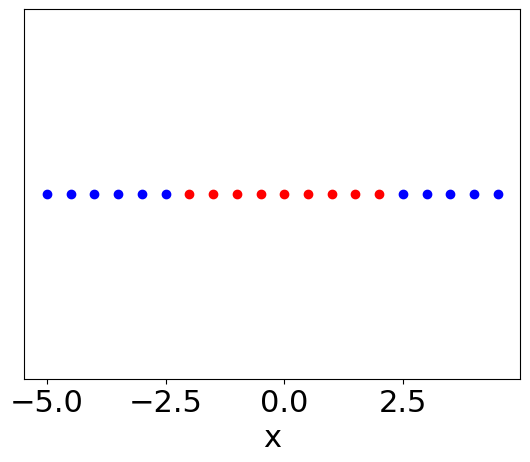

In [7]:
py.plot(x[y==1], 0*x[y ==1],'ro')
py.plot(x[y==-1], 0*x[y ==-1],'bo')    
py.xlabel("x")
fr = py.gca()
fr.axes.get_yaxis().set_visible(False)
py.show()

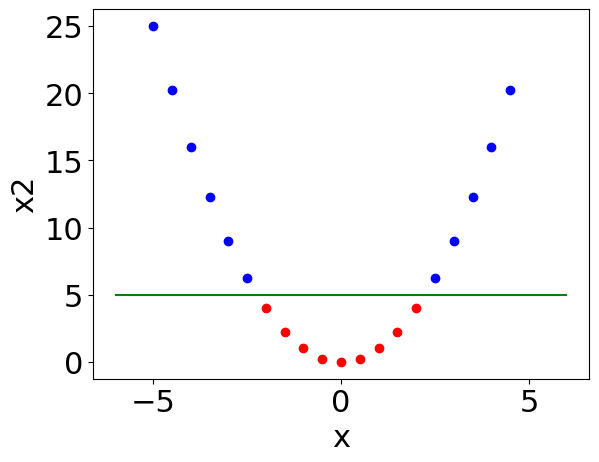

In [8]:
x2 = x**2
py.plot(x[y==1], x2[y ==1],'ro')
py.plot(x[y==-1], x2[y ==-1],'bo')
py.xlabel("x")
py.ylabel("x2")
py.plot([-6, 6],[5,5],'g')
py.show()

Teraz już nie ma problemu aby rozseparować dane liniowo!

## Funkcja mapująca
W ogólności wprowadzimy funkcję mapującą $\phi (x)$, która przenosi punkty z oryginalnej przestrzeni wejściowej do rozszerzonej przestrzeni cech. W powyższym przykładzie byłoby to:

$\qquad$ $
\phi (x) = \left[\begin{array}{c}
x\\
x^{2} \end{array}\right]
$

* Aby skorzystać z takiego mapowania wystarczy w naszych algorytmach uczących zamienić wszędzie $x$ na $\phi (x)$.
* Podobnie możemy postąpić z algorytmem SVM. 
* W postaci dualnej algorytm SVM jest wyrażony całkowicie przez iloczyny skalarne. 
* Możemy zastąpić wszystkie wyrażenia $\langle x, z \rangle $ przez $\langle \phi (x), \phi (z) \rangle $. 

## Jądra
Dla danego mapowania $\phi $ zdefiniujemy jądro (kernel):

$\qquad$ $
K(x,z) = \phi (x)^{T}\phi (z)
$
* Jest to funkcja zwracająca iloczyn skalarny zmapowanych wektorów. 

* wszędzie gdzie w algorytmie występuje $\langle x,z \rangle $ wstawiamy $K(x,z)$ i otrzymujemy algorytm działający w przestrzeni, do której mapuje $\phi $. 

### Sprytne liczenie iloczynów skalarnych: 
* W wielu przypadkach, aby obliczyć $K(x,z)$ nie musimy wcale przechodzić całej drogi: 

$\qquad$ $x \rightarrow \phi (x) \rightarrow \langle \phi (x),\phi (z) \rangle $ 

(taka droga zresztą mogła by być niewykonalna, np. w przypadku mapowania do przestrzeni nieskończenie wymiarowej). 

### Przykład:


$K(x,z) = ( x^{T}z)^{2}$

Rozpisując to wyrażenie na współrzędne otrzymujemy:

$\qquad$ $\begin{matrix}
K(x,z) &=& \left(\sum _{i=1}^{m}x_{i}z_{i} \right) \left(\sum _{j=1}^{m}x_{j}z_{j}\right)\\
&=& \sum _{i=1}^{m}\sum _{j=1}^{m} x_{i}x_{j}z_{i}z_{j}\\
&=& \sum _{i,j=1}^{m}(x_{i}x_{j})(z_{i}z_{j})
\end{matrix}$

Widzimy tu, że jeśli popatrzeć na $K$ tak: $K(x,z) = \phi (x)^{T}\phi (z)$ to owo $K$ związane jest z mapowaniem $\phi $, które w jawnej postaci dla $m=3$ wyglądałoby tak:

$\qquad$ $
\phi (x) = \left[\begin{array}{c}
x_{1}x_{1}\\
x_{1}x_{2}\\
x_{1}x_{3}\\
x_{2}x_{1}\\
x_{2}x_{2}\\
x_{2}x_{3}\\
x_{3}x_{1}\\
x_{3}x_{2}\\
x_{3}x_{3}
\end{array}\right]
$

Zauważmy, że samo obliczenie mapowania w tym przypadku jest operacją o złożoności obliczeniowej $O(m^{2})$ natomiast obliczenie jądra za pomocą równia ($K(x,z) = ( x^{T}z)^{2}$) jest operacją o złożoności obliczeniowej $O(m)$.

Podobne własności ma jądro:

$\qquad$ $
K(x,z) = (x^{T}z + c)^{2} = \sum _{i,j=1}^{m} (x_{i}x_{j})(z_{i}z_{j}) + \sum _{i=1}^{m}(\sqrt{2c}x_{i} )(\sqrt{2c}z_{i}) +c^{2}
$

Jawna postać mapowania odpowiadającego temu jądru wygląda następująco (dla $m=3$):

$\qquad$ $
\phi (x) = \left[\begin{array}{c}
x_{1}x_{1}\\
x_{1}x_{2}\\
x_{1}x_{3}\\
x_{2}x_{1}\\
x_{2}x_{2}\\
x_{2}x_{3}\\
x_{3}x_{1}\\
x_{3}x_{2}\\
x_{3}x_{3} \\
\sqrt{2c}x_{1}\\
\sqrt{2c}x_{2}\\
\sqrt{2c}x_{3}\\
c
\end{array}\right]
$

czyli zawiera zarówno wyrazy pierwszego rzędu ($x_{i}$) oraz drugiego rzędu ($x_{i}x_{j}$). Parametr $c$ kontroluje względny udział części liniowej.

W ogólności jądro postaci $K(x,z) = (x^{T}z + c)^{d}$ odpowiada mapowaniu do $\binom{n+d}{d}$ wymiarowej przestrzeni parametrów, której wymiary są rozpięte przez wszystkie iloczyny typu $x_{i_{1}},x_{i_{2}},\dots ,x_{i_{k}}$ aż do rzędu $d$. Dzięki sztuczce z jądrem nigdy nie musimy jawnie obliczać tych wielowymiarowych wektorów i obliczenia nadal mają złożoność $O(m)$.

## Quiz
* Co robi funkcja mapująca?

* co robi funkcja jądrowa?

## Jakie są inne dobre funkcje jądrowe?
> Na jądro możemy patrzeć jak na funkcję, która jest jakąś miarą podobieństwa pomiędzy wektorami cech.

* W szczególności gdyby nasze wektory cech były znormalizowane do jedynki to duża wartość jądra $K(x,z) = \phi (x)^{T}\phi (z)$ odpowiadałaby wektorom bardzo podobnym, zaś wartość jądra bliska zeru odpowiadałaby wektorom cech, które są do siebie prawie ortogonalne, tzn. mało podobne.

* Idąc tym tropem możemy zapostulować także inne funkcje jądra, które w jakimś sensie mogłyby stanowić miarę podobieństwa między wektorami. 
* Popularną funkcją jest np. funkcja Gaussa, prowadząca do <b>jądra Gaussowskiego</b> następującej postaci:

$\qquad$ $
K(x,z) = \exp \left( - \frac{||x-z||^{2}}{2 \sigma ^{2}}\right)
$

<img src="https://image.slidesharecdn.com/svm-140807035301-phpapp01/95/support-vector-machine-without-tears-28-638.jpg?cb=1407384107">

> Jak w ogólności sprawdzić czy wymyślona przez nas funkcja jest dobrym kandydatem na jądro?

* Rozważymy to najpierw na przykładzie a potem podamy ogólne twierdzenie.

### Przykład
Załóżmy, że mamy pewną funkcję $K$, która jest jądrem pewnego mapowania $\phi $. Załóżmy dalej, że mamy pewien zbiór $m$ punktów $\lbrace x^{(1)},\dots ,x^{(m)}\rbrace $. Zdefiniujmy macierz $\mathbf {K}$ zwaną macierzą jądra w taki sposób, że jej $i,j$ element dany jest wzorem:

$\qquad$ $
\mathbf {K}_{i,j} = K(x^{(i)},x^{(j)})
$

* Zauważmy, że macierz ta musi być symetryczna, bo:

$\qquad$ $
\mathbf {K}_{i,j} = K(x^{(i)},x^{(j)}) =\phi (x^{(i)})^{T}\phi (x^{(j)}) = \phi (x^{(j)})^{T}\phi (x^{(i)}) = K(x^{(j)},x^{(i)}) = \mathbf {K}_{j,i}
$

* Druga obserwacja jest następująca:
  * Niech $\phi _{k}(x)$ oznacza $k$-tą współrzędną wektora $\phi (x)$. 
  * Wtedy dla dowolnego wektora $z$ mamy:

$\qquad$ $\begin{matrix}
z^{T}\mathbf {K}z &=& \sum _{i}\sum _{j} z_{i}\mathbf {K}_{i,j}z_{j} \\
&=& \sum _{i}\sum _{j} z_{i}\phi (x^{(i)})^{T}\phi (x^{(j)})z_{j} \\
&=& \sum _{i}\sum _{j} z_{i} \sum _{k} \phi _{k}(x^{(i)})\phi _{k}(x^{(j)})z_{j} \\
&=& \sum _{k}\sum _{i}\sum _{j} z_{i}\phi _{k}(x^{(i)})\phi _{k}(x^{(j)})z_{j} \\
&=& \sum _{k} \left( \sum _{i} z_{i} \phi _{k}(x^{(i)})\right)^{2} \\
&\ge & 0
\end{matrix}$

Ponieważ powyższe obliczenie pokazuje, że dla dowolnego $z$ wyrażenie $z^{T}\mathbf {K}z$ jest nieujemne to oznacza, że macierz $\mathbf {K}$ jest dodatnio określona.

## Twierdzenie Mercera
* Pokazaliśmy w tym przykładzie, że:
 > jeśli mamy jakieś mapowanie $\phi $ i związane z nim jądro $K$ to macierz jądra jest symetryczna i dodatnio określona. 

* Okazuje się, że jest to warunek konieczny i wystarczający, aby funkcja $K$ była jądrem, jest to twierdzenie Mercera.

## Zastosowania podejścia jądrowego
Warto sobie uświadomić, że podejście "jądrowe" ma znacznie szersze zastosowanie niż tylko algorytm SVM. 

* Jeśli tylko jesteśmy w stanie wyrazić algorytm w postaci bazującej na iloczynach skalarnych $\langle x,z \rangle $ (da się to w szczególności zrobić np. dla regresji logistycznej) to zamiana tych iloczynów na funkcje jądra daje nam algorytm działający efektywnie w przestrzeni, do której przenosi nas odwzorowanie $\phi $. 
* Dzięki temu można spowodować, że wiele problemów, które nie są separowalne liniowo w pierwotnej przestrzeni wejść staje się separowalna liniowo w tej nowej, więcej wymiarowej przestrzeni.

## Quiz
* Co to jest liniowa separowalność?

## Regularyzcja i przypadki nieseparowalne liniowo

* Zaprezentowana dotychczas wersja SVM zakładała, że dane są liniowo separowalne. 
* Sztuczka z jądrem mapującym zwiększa co prawda szansę na otrzymanie problemu liniowo separowalnego, ale nie daje na to gwarancji. 
* Co więcej w dotychczasowej wersji nasz algorytm SVM jest bardzo podatny na outliery, czyli przypadki odstające.
(Pokażemy to na ćwiczeniach)

## Jak to poprawić?
Aby poprawić oba te problemy można zastosować regularyzację:

$\qquad$ $\begin{matrix}
\min _{ w, b}&& \frac{1}{2}||w||^{2} + C\sum _{j=1}^{m}\xi _{j}\\
\text{pod warunkiem: }&& y^{(j)}(w^{T}x^{(j)} +b ) \ge 1- \xi _{j}, \quad j=1,\dots ,m\\
&& \xi _{j} \ge 0, \quad j=1,\dots ,m
\end{matrix}$

* Oznacza ona tyle, że zgadzamy się na to, że nie wszystkie marginesy funkcyjne są większe niż 1 (przypomnijmy, że ujemny margines funkcyjny odpowiadał złej klasyfikacji), 
* ale karzemy algorytm za naruszanie tego warunku przez zwiększanie funkcji celu.
* Parametr $C$ kontroluje jak bardzo nie podoba nam się błędne klasyfikowanie przypadków.

### Lagrangian
Formułujemy Lagrangian następującej postaci:

$\qquad$ $
\mathcal {L}(w,b,\xi ,\alpha ,r) = \frac{1}{2}w^{T}w + C\sum _{j=1}^{m}\xi _{j} - \sum _{j=1}^{m}\alpha _{j}[y^{(j)}(x^{T}w +b)-1 +\xi _{j}] - \sum _{j=1}^{m}r_{j}\xi _{j}
$

gdzie $\alpha _{j}\ge 0$ i $r_{j}\ge 0$ są mnożnikami Lagrangea. 

### Przejście do postaci dualnej
Przejście do postaci dualnej polega na:
* policzeniu pochodnej Lagrangianu względem $w$ i $b$, 
* przyrównaniu od zera i podstawieniu otrzymanych wyrażeń ponownie do Lagragianu  
* otrzymujemy problem dualny następującej postaci:


$\begin{matrix}
\max _{\alpha } && \theta _{d}(\alpha ) = \sum _{j=1}^{m}\alpha _{j} - \frac{1}{2} \sum _{i,j =1}^{m} y^{(i)}y^{(j)}\alpha _{i}\alpha _{j} \langle x^{(i)},x^{(j)} \rangle \\
\text{pod warunkiem: } && 0 \le \alpha _{j} \le C, \quad j=1,\dots ,m\\
&&\sum _{j=1}^{m}\alpha _{j}y^{(j)} = 0
\end{matrix}$


Do rozwiązania powyższego problemu dobrze stosuje się algorytm SMO (Sequential Minimal Optimization) [[https://www.researchgate.net/publication/2624239_Sequential_Minimal_Optimization_A_Fast_Algorithm_for_Training_Support_Vector_Machines opis algorytmu zaproponowanego przez J. Platta (1998)]]. Po wyznaczeniu za jego pomocą parametrów $\alpha $ i $b$ można wykonywać predykcję nowych przykładów.

## Algorytm SMO - sekwencyjnej minimalnej optymalizacji

Zanim przejdziemy do omówienia właściwego algorytmu SMO zrobimy dygresję na temat optymalizacji osiowej.

### Optymalizacja osiowa

Załóżmy, że chcemy rozwiązać następujący problem optymalizacyjny bez więzów:

$\qquad$ $
\max _{\alpha } W (\alpha _{1},\dots ,\alpha _{m})
$

Jeśli funkcja $W$ jest wypukła to algorytm, który w pętli kolejno optymalizuje jedno $\alpha _{i}$, trzymając w danym kroku optymalizacyjnym pozostałe alfy stałe, jest zbieżny.

<a title="Nicoguaro [CC BY 4.0 (https://creativecommons.org/licenses/by/4.0)], from Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Coordinate_descent.svg"><img width="512" alt="Coordinate descent" src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e3/Coordinate_descent.svg/512px-Coordinate_descent.svg.png"></a>

### Algorytm SMO

* Chcemy rozwiązać problem optymalizacyjny SVM z regularyzacją. 
* Nie da się do niego zastosować algorytmu optymalizacji osiowej bo drugi warunek narzuca więzy na $\alpha $. 
  * Jeśli ustalimy $m-1$ wartości $\alpha _{j}$ to ostatnia $m$-ta wartość też już jest ustalona:

$\qquad$ $
\alpha _{i}y^{(i)} = -\sum _{j \ne i} \alpha _{j}y^{(j)}
$

Lub korzystając z faktu, że $y^{(i)} = \lbrace -1,1\rbrace $ i mnożąc stronami przez $y^{(i)}$ mamy: $\alpha _{i}= -y^{(i)} \sum _{j \ne i} \alpha _{j}y^{(j)}$.

Zatem najmniejszy możliwy problem optymalizacyjny wymaga jednoczesnej optymalizacji dwóch parametrów $\alpha $.

Najogólniej algorytm SMO wygląda więc następująco:

Powtarzaj, aż zbiegniesz:



* Wybierz parę $\alpha _{i}$ i $\alpha _{j}$ do optymalizacji (na podstawie heurystyki szacującej, która para da największe zbliżenie do maksimum).

*	Popraw $\theta _{d}(\alpha )$ biorąc pod uwagę $\alpha _{i}$ i $\alpha _{j}$ trzymając pozostałe alfy stałe.

Testem na zbieżność są tu warunki KKT, które powinny zostać spełnione z zadaną tolerancją.

Rozważmy krok 2. powyższego algorytmu. Załóżmy, że chcemy wykonać maksymalizację ze względu na parametry $\alpha _{1}$ i $\alpha _{2}$ trzymając pozostałe parametry $\alpha _{3}, \dots ,\alpha _{m}$ stałe. Z drugiego warunku mamy:


$
\alpha _{1}y^{(1)}+ \alpha _{2}y^{(2)} = - \sum _{i=3}^{m} \alpha _{i} y^{(i)} = \zeta 
$


gdzie $\zeta $ jest stałą.
Oznacza to, że punkt $(\alpha _{1},\alpha _{2})$ będący rozwiązaniem musi leżeć na prostej $\alpha _{1}y^{(1)}+ \alpha _{2}y^{(2)} =\zeta $.

<img src="https://www.fuw.edu.pl/~jarekz/WYKLADY/UM/W5_SVM/fig_smo_1.png"  height=200 width=300>

Przekształcając powyższe równanie mamy:

$\qquad$ $
\alpha _{1} = \frac{ \zeta -\alpha _{2}y^{(2)} }{ y^{(1)}}
$

Zatem funkcja celu może być zapisana jako:

$\qquad$ $
\theta _{d}(\alpha _{1},\alpha _{2},\alpha _{3},\dots ,\alpha _{m}) = \theta _{d}(\frac{\zeta - \alpha _{2}y^{(2)}}{y^{(1)}}, \alpha _{2},\alpha _{3},\dots ,\alpha _{m})
$

* Ponieważ trzymamy w tym kroku parametry $\alpha _{3}, \dots ,\alpha _{m}$ jako stałe to funkcja celu jest funkcją kwadratową parametru $\alpha _{2}$. 

* Można by ją zapisać w postaci 
$\qquad$ $\theta _{d}(\alpha _{2})=a\alpha _{2}^{2}+b\alpha _{2}+c$
dla odpowiednio dobranych $a,b$ i $c$. 

* Łatwo można zmaksymalizować analitycznie funkcję $\theta _{d}(\alpha _{2})$ w przypadku swobodnym, a następnie przyciąć rozwiązanie do "pudełka" wynikającego z więzów.


## Quiz
* dlaczego rozwiązująć problem SVM rozwiazujemy w każdej iteracji względem dwóch $\alpha$ naraz?

# Podsumowanie: Typy klasyfikatrów liniowych
<img src="https://www.fuw.edu.pl/~jarekz/WYKLADY/UM/W5_SVM/typy_klasyfikatorów_liniowych.png"  height=800 width=1200>
